# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [3]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt 
import numpy as np

from LANAM.models import LaNAM, NAM, BayesianLinearRegression

from LANAM.config import defaults, nam_defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *
from LANAM.trainer.feature_interaction_selection import *
from LANAM.trainer.nam_trainer import *

from LANAM.data.generator import *
from LANAM.data.dataset import *

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter
from LANAM.utils.wandb import *

from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN

import wandb 
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [4]:
use_wandb = False
if use_wandb:
    wandb.login()

In [5]:
%reload_ext autoreload
%autoreload 2

In [90]:
sigma = 0.7
# training and validation sets
data = load_synthetic_data(sigma=sigma, sampling_type='normal')

train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()

in_features = data.in_features

In [96]:
test_data = load_synthetic_data(sigma=sigma, sampling_type='normal', x_lims=(-0.2, 1.2))
test_dl, test_dl_fnn = test_data.test_dataloaders()
test_samples = test_data.get_test_samples()

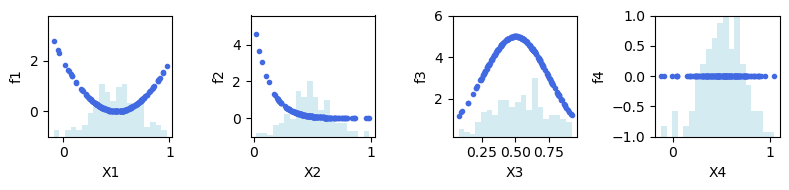

In [97]:
test_data.plot_dataset(subset='test')

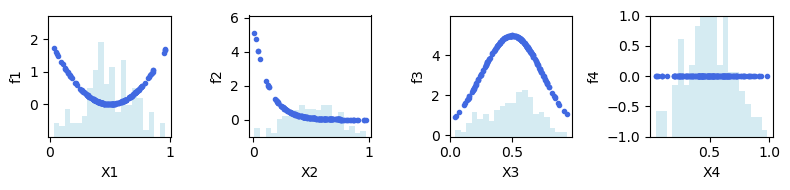

In [91]:
data.plot_dataset(subset='test')

Configuration: Config(experiment_name='NAM-grid', seed=2023, prior_sigma_noise=0.7, regression=True, use_dnn=False, num_epochs=500, batch_size=256, shuffle=True, early_stopping_patience=50, decay_rate=0.005, logdir='./output', wandb=False, log_loss_frequency=100, lr=0.001, l2_regularization=1e-05, output_regularization=0, dropout=0.2, feature_dropout=0.05, hidden_sizes=[64], activation_cls='gelu', num_ensemble=10)
[EPOCH=100]: Train_Loss: 3.2193708419799805, Val_Loss: 1.453144907951355, Train_MSE: 3.2189882596333823, Val_MSE: 1.452763068675995
[EPOCH=200]: Train_Loss: 2.653994560241699, Val_Loss: 0.9124805331230164, Train_MSE: 2.6536375919977826, Val_MSE: 0.9121239185333252
[EPOCH=300]: Train_Loss: 2.4929158687591553, Val_Loss: 0.7192174196243286, Train_MSE: 2.4925891319910685, Val_MSE: 0.7188909649848938
[EPOCH=400]: Train_Loss: 2.378492593765259, Val_Loss: 0.6891139149665833, Train_MSE: 2.3782023628552755, Val_MSE: 0.6888237357139587
[EPOCH=500]: Train_Loss: 2.2038989067077637, Val_L

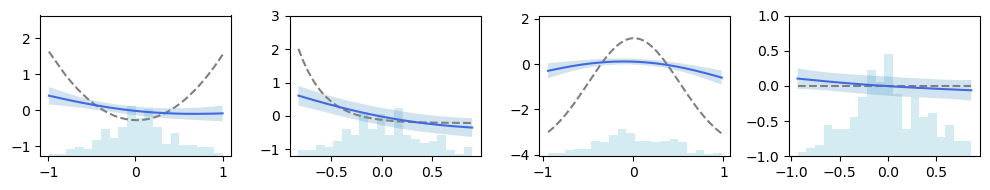

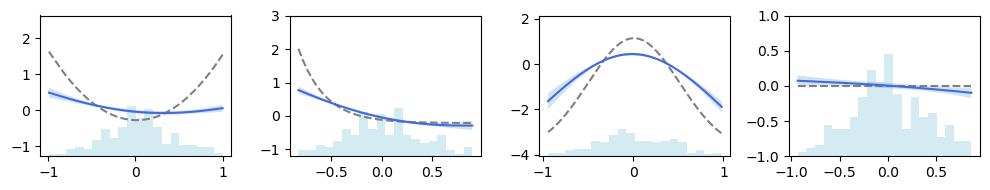

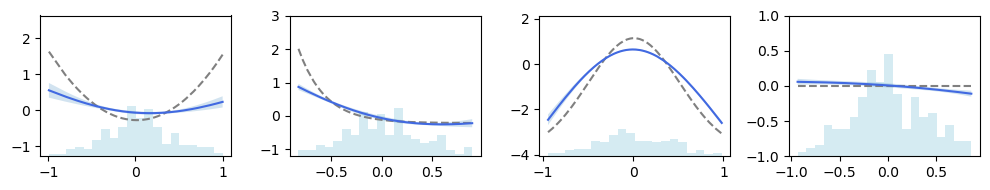

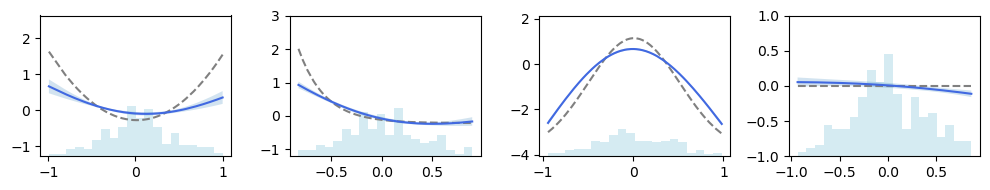

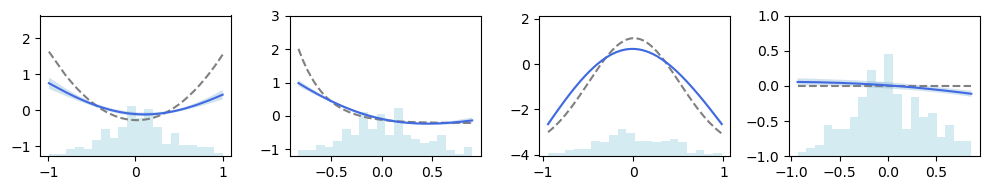

In [43]:
nam_cfg = nam_defaults()
nam_cfg.activation_cls = 'gelu'
nam = NAM(
    config=nam_cfg, 
    name="NAM", 
    in_features=in_features)

nam = train(nam_cfg, 
            train_dl, 
            val_dl, 
            test_samples=test_samples, 
            ensemble=True, 
            use_wandb=False) 

In [44]:
print(test('regression', 'cpu', nam, test_dl))

tensor(0.6825)


In [99]:
cfg = defaults()
fullm = LaNAM(config=cfg, 
              name="LaNAM", 
              in_features=in_features, 
              hessian_structure='full', 
              subset_of_weights='all')

print(fullm)

LaNAM(
  (_feature_nns): ModuleList(
    (0-3): 4 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)


[Epoch=100, MSE: 0.7022107243537903, n_hypersteps=29]: prior precision: [0.13658541 0.1326635  0.11726344 0.14403798], sigma noise: [0.47339547 0.4798256  0.49572283 0.46597683]
[Epoch=200, MSE: 0.5507583022117615, n_hypersteps=29]: prior precision: [0.09251761 0.0848984  0.06212187 0.1356877 ], sigma noise: [0.39095753 0.40053433 0.4171207  0.36513588]
MARGLIK: finished training. Recover best model and fit Laplace.
Training time: 4.862s


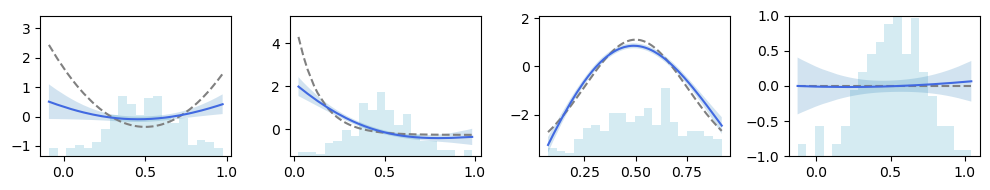

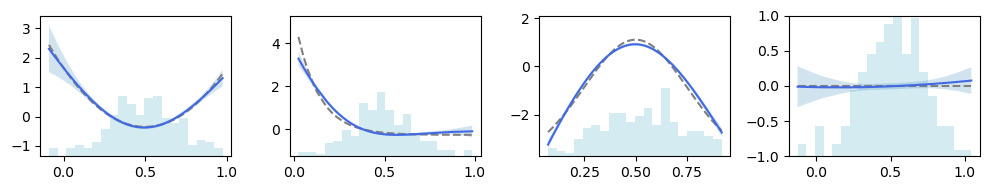

In [100]:
start = time.time()
fullm, fullmargs, fulllosses, fullperfs = marglik_training(fullm, 
                                                           train_dl, 
                                                           train_dl_fnn, 
                                                           test_dl, 
                                                           likelihood='regression', 
                                                           test_samples=test_samples,
                                                           n_epochs=200, 
                                                           use_wandb=False, 
                                                           optimizer_kwargs={'lr': 1e-2}, 
                                                           plot_recovery=True)
end = time.time()
print(f'Training time: {end-start:.3f}s')
features, targets, feature_targets = test_samples

In [49]:
print(test('regression', 'cpu', fullm, test_dl))

tensor(0.4802)


In [48]:
test_wandb_log = False
if test_wandb_log:
    project_name = 'Datasets'
    artifact_name = 'concurvity-7'
    table_name = 'concurvity-7'
    log_LANAMSyntheticDataset(data, 
                              project_name, 
                              artifact_name, 
                              table_name)

    #dataset = load_LANAMSyntheticDataset(project_name, 'synthetic-8:v0', table_name)

In [54]:
data = load_autompg_data()

in_features = data.in_features

train_dl, train_dl_fnn, val_dl, val_dl_fnn = data.train_dataloaders()
test_dl, test_dl_fnn = data.test_dataloaders()


In [55]:
cfg = defaults()
cfg.activation_cls = 'gelu'
in_features 
fullm = LaNAM(config=cfg, 
              name="LaNAM", 
              in_features=in_features, 
              hessian_structure='full', 
              subset_of_weights='all')

print(fullm)

start = time.time()
fullm, fullmargs, fulllosses, fullperfs = marglik_training(fullm, 
                                                           train_dl, 
                                                           train_dl_fnn, 
                                                           test_dl, 
                                                           likelihood='regression', 
                                                           n_epochs=800, 
                                                           use_wandb=False, 
                                                           optimizer_kwargs={'lr': 1e-2}, 
                                                           plot_recovery=True)
end = time.time()
print(f'Training time: {end-start:.3f}s')
#test_X, test_y, test_feature_out = data.get_test_samples()

LaNAM(
  (_feature_nns): ModuleList(
    (0-6): 7 x FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
)
[Epoch=100, MSE: 7.430317401885986, n_hypersteps=29]: prior precision: [0.12347059 0.12741728 0.12881787 0.12432164 0.12418815 0.12557337
 0.12164629], sigma noise: [1.013978  1.0828409 1.111923  1.1622354 1.0468576 1.1493857 0.9483226]
[Epoch=200, MSE: 6.732366561889648, n_hypersteps=29]: prior precision: [0.07994886 0.09257562 0.09740406 0.07854835 0.08432708 0.08717338
 0.07367988], sigma noise: [0.980739  1.0250102 1.1066535 1.1372983 1.0562626 1.0999106 0.8807561]
[Epoch=300, MSE: 6.495691776275635, n_hypersteps=29]: prior precision: [0.08271215 0.10266165 0.10960271 0.07949466 0.08857512 0.09296922
 0.07131675], sigma noise: [0.96795744 0.9867438  1.0793093  1.1096846  1.0478823  1.0672895
 0.856208  ]
[Epoch=4

In [44]:
print(fullm.additive_sigma_noise)

tensor(2.7484, grad_fn=<SqrtBackward0>)


In [53]:
print(test(cfg, fullm, test_dl))
print(test(cfg, model, test_dl))

tensor(2.8522)
tensor(98.4027)


In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits, None

    
cfg = defaults()
dnn = NeuralNetwork(in_features)
train(cfg, dnn, train_dl, val_dl)

=============EPOCH 1==============
loss_train:  595.852, loss_val:  352.761
=============EPOCH 101==============
loss_train:  5.787, loss_val:  3.257
=============EPOCH 201==============
loss_train:  4.919, loss_val:  4.088
=============EPOCH 301==============
loss_train:  4.249, loss_val:  5.076
=============EPOCH 401==============
loss_train:  4.290, loss_val:  5.413
=============EPOCH 501==============
loss_train:  3.748, loss_val:  4.893
=============EPOCH 601==============
loss_train:  3.473, loss_val:  6.027
=============EPOCH 701==============
loss_train:  3.275, loss_val:  6.304
=============EPOCH 801==============
loss_train:  4.287, loss_val:  7.106
=============EPOCH 901==============
loss_train:  3.957, loss_val:  8.947
Finished Training.


911.0338745117188

In [40]:
fullm = LaNAM(config=cfg, 
              name="LaNAM", 
              in_features=in_features, 
              hessian_structure='full', 
              subset_of_weights='all')
train(cfg, fullm, train_dl, val_dl)

=============EPOCH 1==============
loss_train:  532.642, loss_val:  55.715
=============EPOCH 101==============
loss_train:  6.718, loss_val:  5.904
=============EPOCH 201==============
loss_train:  6.530, loss_val:  6.018
=============EPOCH 301==============
loss_train:  6.228, loss_val:  4.827
=============EPOCH 401==============
loss_train:  6.197, loss_val:  4.475
=============EPOCH 501==============
loss_train:  6.105, loss_val:  5.935
=============EPOCH 601==============
loss_train:  6.162, loss_val:  3.979
=============EPOCH 701==============
loss_train:  5.867, loss_val:  5.544
=============EPOCH 801==============
loss_train:  5.995, loss_val:  6.407
=============EPOCH 901==============
loss_train:  6.371, loss_val:  4.139
Finished Training.


1623.338134765625

In [52]:
from nam.models import NAM
from nam.config import defaults as defau

config = defau()
config.hidden_sizes=[]
model = NAM(
  config=config,
  name="NAM_GALLUP",
  num_inputs=in_features,
  num_units=1024,
)
model
train(cfg, model, train_dl, val_dl)

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2023-03/6a700484/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([31, 1])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


=============EPOCH 1==============
loss_train:  10603.237, loss_val:  1720753.806
=============EPOCH 101==============
loss_train:  194.413, loss_val:  2792.566
=============EPOCH 201==============
loss_train:  142.826, loss_val:  2364.418
=============EPOCH 301==============
loss_train:  136.701, loss_val:  2446.627
=============EPOCH 401==============
loss_train:  124.290, loss_val:  2188.919
=============EPOCH 501==============
loss_train:  114.031, loss_val:  2023.867
=============EPOCH 601==============
loss_train:  160.488, loss_val:  2872.503
=============EPOCH 701==============
loss_train:  304.821, loss_val:  2032.444
=============EPOCH 801==============
loss_train:  89.730, loss_val:  2107.746
=============EPOCH 901==============
loss_train:  89.047, loss_val:  2305.420
Finished Training.


35062.453125

In [42]:
fullm = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full', subset_of_weights='all')

start = time.time()
fullm, fullmargs, fulllosses, fullperfs = marglik_training(fullm, trainset.loader, trainset.loader_fnn, 'regression', 
                                                           n_epochs=600, use_wandb=False,optimizer_kwargs={'lr': 1e-2})
end = time.time()
print(f'Training time: {end-start:.3f}s')

NameError: name 'trainset' is not defined

In [5]:
print(f"Sigma noise: {fullm.sigma_noise.detach().numpy()}")
print(f"Prior precision: {fullm.prior_precision.detach().numpy()}")
print(f"Additive sigma noise: {fullm.additive_sigma_noise}")

Sigma noise: [0.21547389 0.17701066 0.17723943 0.19058715 0.1987332  0.23642804
 0.17901869]
Prior precision: [0.3637297  1.1419666  1.1481379  0.6917585  0.9474977  0.26781145
 0.802858  ]
Additive sigma noise: 0.5224364399909973


In [6]:
k_pairs, sorted_mis = feature_interaction_selection(fullm, trainset.loader, subset_of_weights='last_layer')

In [ ]:
fullm.extend_joint_feature_nets(k_pairs)

In [ ]:
cfg.activation_cls = 'relu'
kronm = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='kron', subset_of_weights='all')
print(kronm)
start = time.time()
kronm, kronmargs, kronlosses, kronperfs = marglik_training(
    kronm, trainset.loader, trainset.loader_fnn, 'regression', testset=testset, n_epochs=20,
    n_epochs_burnin=0, n_hypersteps=30, marglik_frequency = 5,
    use_wandb=False, optimizer_kwargs={'lr': 1e-2})
end = time.time()

print(f'Training time: {end-start:.3f}s')

print(f"Sigma noise: {kronm.sigma_noise.detach().numpy()}")
print(f"Prior precision: {kronm.prior_precision.detach().numpy()}")
print(f"Additive sigma noise: {kronm.additive_sigma_noise}")